<a href="https://colab.research.google.com/github/PhilipMathieu/access/blob/main/notebooks/0d%20portland_greenspace_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install necessary libraries
!pip install --upgrade geopandas contextily osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import json
import urllib.parse
import os.path
import contextily as cx
ox.settings.cache_folder = "../cache/"

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16,9)
mpl.rcParams['savefig.dpi'] = 300

## Set Boundary

Load a shapefile containing the boundary of the city of Portland, ME. This will be used to determine which Census blocks to include.

In [8]:
portland_boundary = gpd.read_file("https://services1.arcgis.com/RbMX0mRVOFNTdLzd/arcgis/rest/services/Maine_Town_and_Townships_Boundary_Polygons_Dissolved/FeatureServer/0/query?where=TOWN%20%3D%20'PORTLAND'&outFields=*&outSR=4269&f=json")

## Load census blocks

In [4]:
!wget -nc https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/23_MAINE/23005/tl_2020_23005_tabblock20.zip -P ../data/blocks/

--2023-05-03 12:44:12--  https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/23_MAINE/23005/tl_2020_23005_tabblock20.zip
Resolving www2.census.gov (www2.census.gov)... 173.222.233.71, 2600:1409:12:28d::208c, 2600:1409:12:2b9::208c
Connecting to www2.census.gov (www2.census.gov)|173.222.233.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘../data/blocks/tl_2020_23005_tabblock20.zip’

tl_2020_23005_tabbl     [             <=>    ]   3.87M   857KB/s    in 4.6s    

2023-05-03 12:44:17 (870 KB/s) - ‘../data/blocks/tl_2020_23005_tabblock20.zip’ saved [4062245]



In [12]:
blocks = gpd.read_file("../data/blocks/tl_2020_23005_tabblock20.zip").set_index('GEOID20').clip(portland_boundary).to_crs('EPSG:3857')

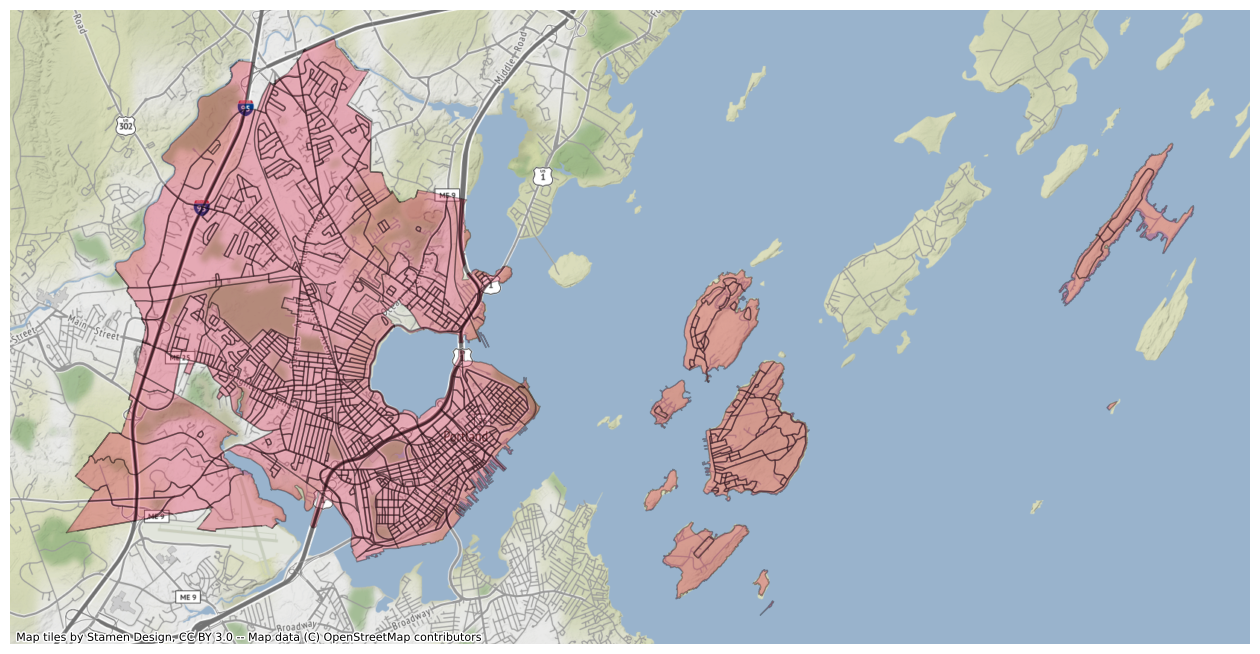

In [28]:
ax = blocks.plot(alpha=0.3, facecolor='crimson', edgecolor='k')
ax.axis('off')
cx.add_basemap(ax)

Because this approach assumes walking distance, results aren't valid for "blocks" that are primarily areas of water. We can filter these out using the 'AWATER20' column.

In [30]:
# manually remove islands
blocks = blocks[blocks['AWATER20'] == 0]

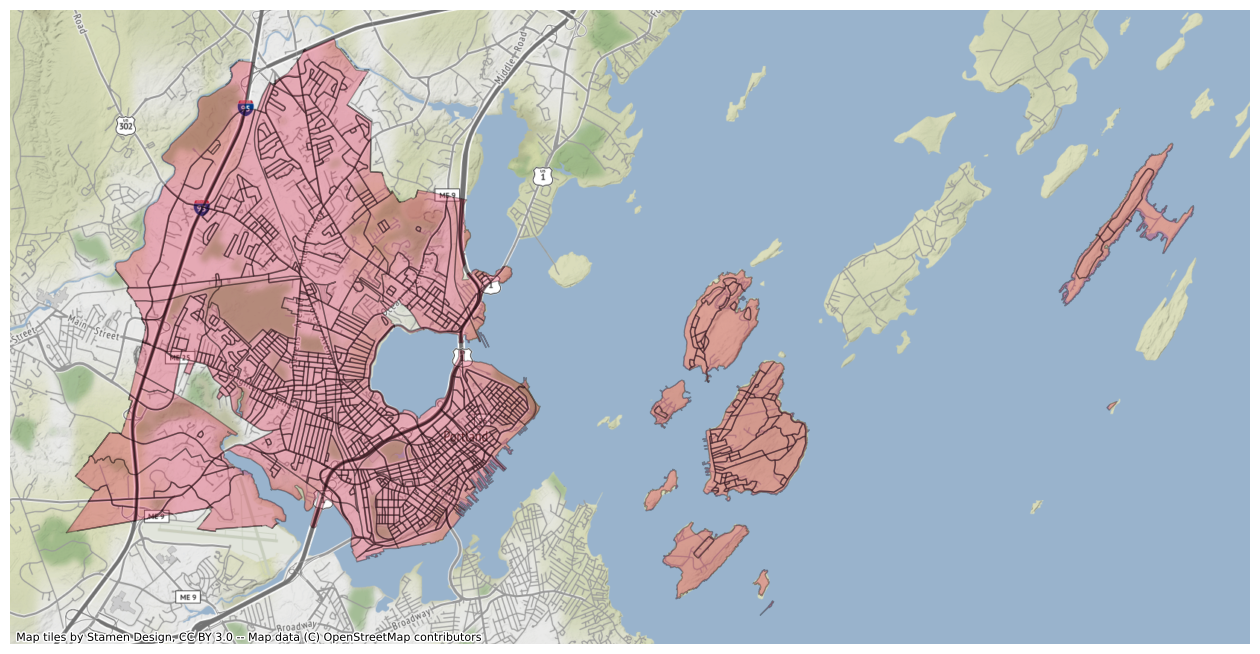

In [31]:
ax = blocks.plot(alpha=0.3, facecolor='crimson', edgecolor='k')
ax.axis('off')
cx.add_basemap(ax)

## Download and prep the street network

This is usually the most time-consuming step, as the size of the graph could be arbitrarily large. To speed up computation, download the graph separately and load it from local storage.

In [29]:
filepath = "../data/graphs/greater_portland.graphml"

if os.path.isfile(filepath):
  # load from file
  G = ox.load_graphml(filepath)
else:
  # download the street network
  bbox = blocks.to_crs("EPSG:4326").geometry.unary_union.envelope.bounds
  buffer = 0.05 # unit is lat/lon degrees
  network_type = "walk"
  G = ox.graph_from_bbox(bbox[3]+buffer, bbox[1]-buffer, bbox[2]+buffer, bbox[0]-buffer, network_type=network_type)
  ox.save_graphml(G, filepath)

G = ox.project_graph(G, 'EPSG:3857') # project the graph to UTM for this zone

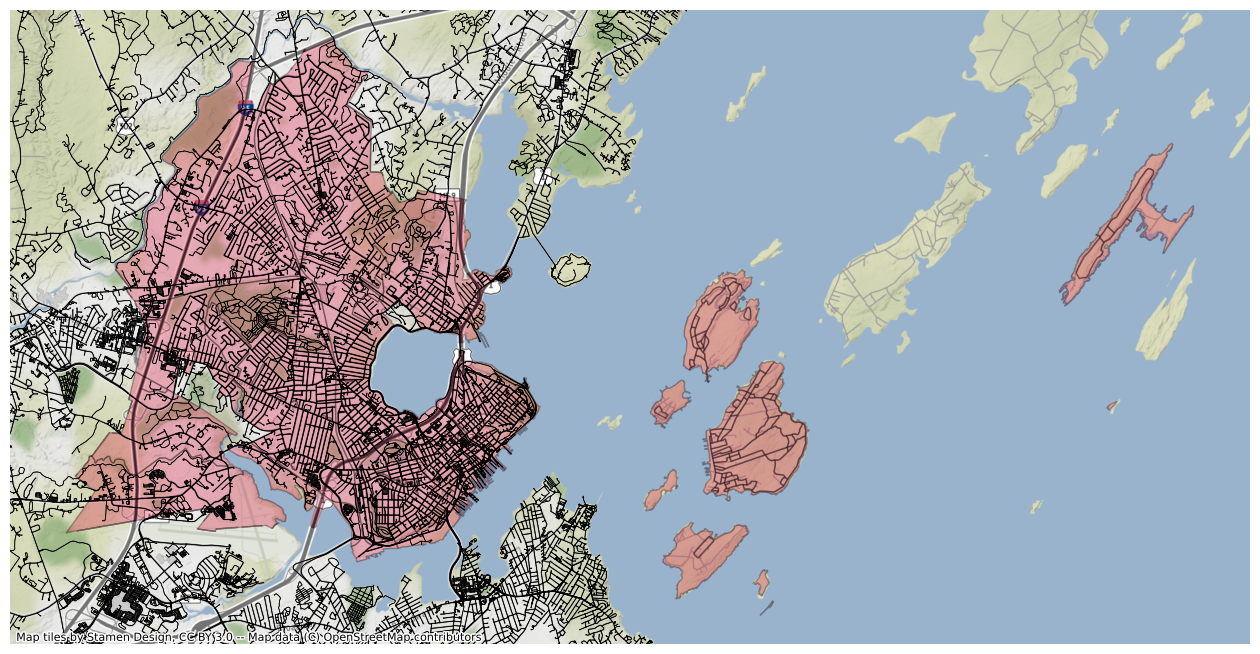

In [46]:
ax = blocks.plot(alpha=0.3, facecolor='crimson', edgecolor='k')
ax.axis('off')
bbox_nsew = tuple(reversed(ax.get_xlim() + ax.get_ylim()))
ox.plot_graph(G, ax=ax, bgcolor=None, show=False, close=False, node_size=1, bbox=bbox_nsew, node_color='k', edge_color='k', edge_linewidth=0.5)
cx.add_basemap(ax)

For each census tract, we need to find the closest node on the graph. (This will allow us to compute distance entirely in terms of graph distance, as opposed to relying on spatial projections which are both slower and possibly less accurate.)

Median Distance:  79 m


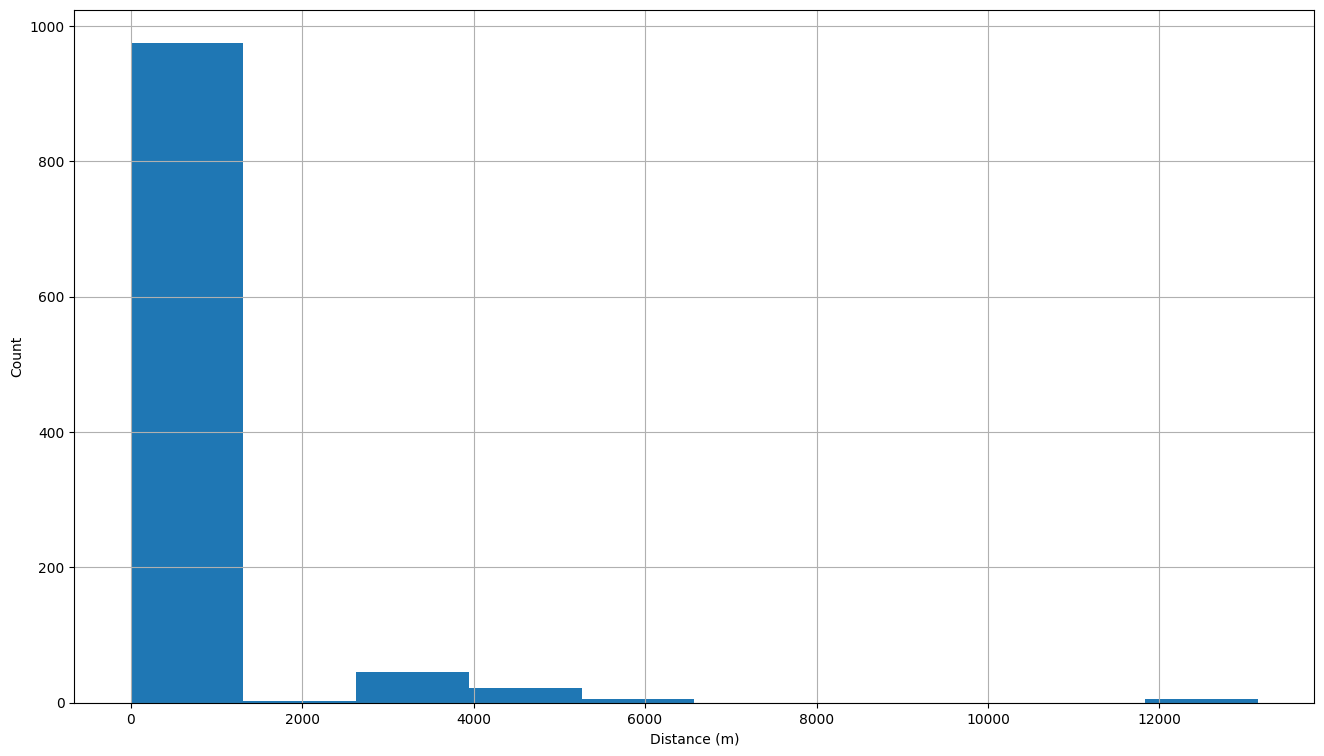

In [51]:
# use a spatial index to efficiently find nearest nodes
gdf_nodes = ox.graph_to_gdfs(G, edges=False).reset_index()
center_nodes = gdf_nodes.loc[gdf_nodes.sindex.nearest(blocks.centroid)[1]]["osmid"].values
center_nodes_gdf = ox.graph_to_gdfs(G, edges=False).loc[center_nodes]

# verify that nodes are reasonably close
center_nodes_gdf['distance'] = center_nodes_gdf.distance(blocks.centroid, align=False)
ax = center_nodes_gdf['distance'].hist()
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Count")
print(f"Median Distance: {center_nodes_gdf['distance'].median():3.0f} m")

There's clearly an issue here. The median distance is just 79 m, but there are several nodes with distances over a kilometer. Further investigation would show that this happens when the islands are mapped to nodes on the mainland. To dodge this issue, we can filter nodes where the distance is too high (say, >500m)

In [53]:
center_nodes_gdf = center_nodes_gdf[center_nodes_gdf['distance'] < 500]

Median Distance:  72 m


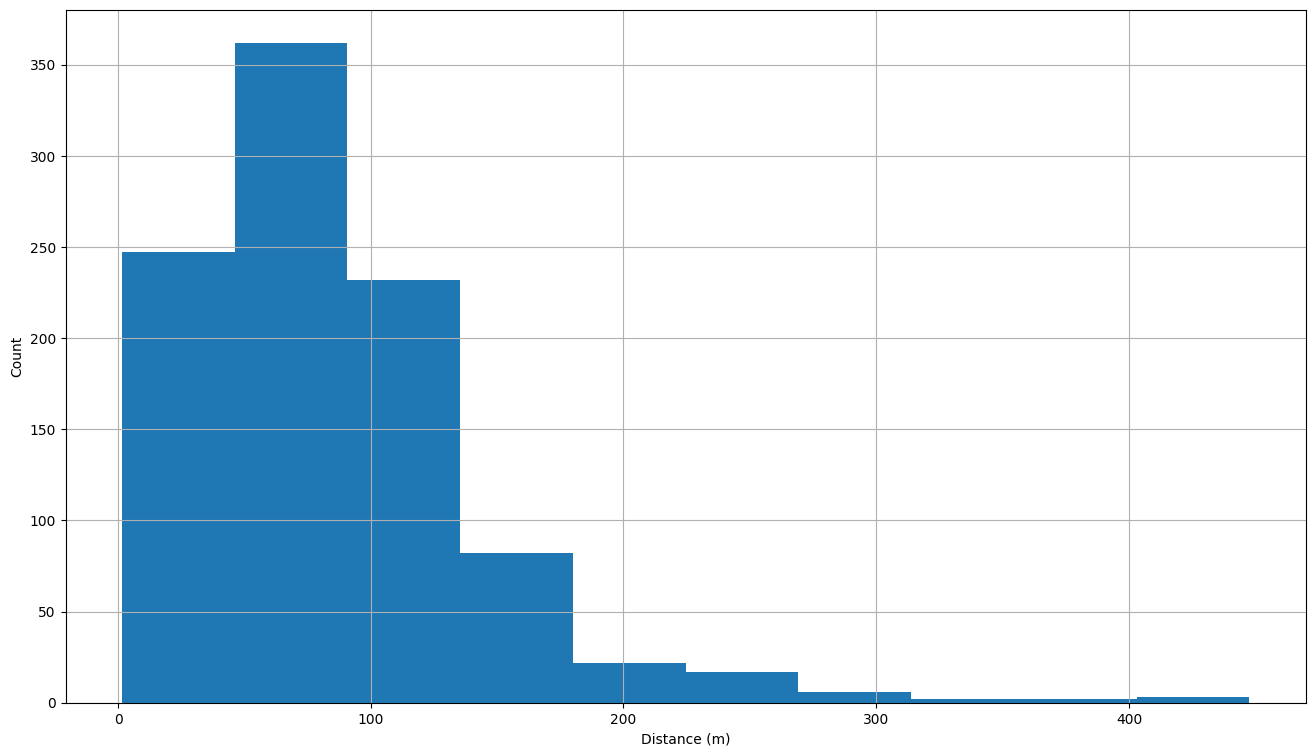

In [54]:
ax = center_nodes_gdf['distance'].hist()
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Count")
print(f"Median Distance: {center_nodes_gdf['distance'].median():3.0f} m")

## Plot nodes you can reach on foot within each time

How far can you walk in 5, 10, 15, 20, 30, 45, and 60 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [55]:
# configure trip times and travel speed
trip_times = [5, 10, 15, 20, 30, 45, 60]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

In [56]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [57]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

Processing Node 101277094


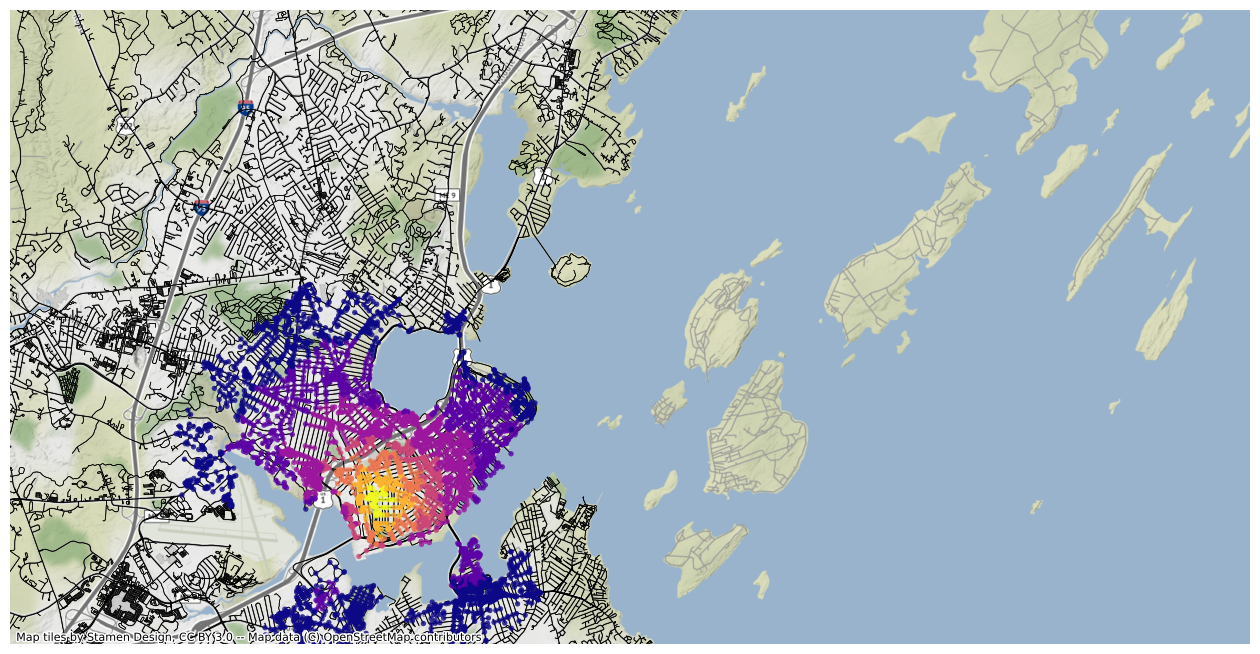

In [65]:
center_node = center_nodes[42]
print(f"Processing Node {center_node}")
# color the nodes according to isochrone then plot the street network
node_times = {}
node_colors = {}
# loop over allowed trip times
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    # find subgraph from center node
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    # color nodes according to the isoline
    for node in subgraph.nodes():
        node_times[node] = trip_time
        node_colors[node] = color
# set node size and color for unreachable nodes
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
# show the result
fig, ax = ox.plot_graph(
    G,
    bgcolor=None,
    node_color=nc,
    node_size=ns,
    bbox=bbox_nsew,
    edge_color='k',
    edge_linewidth=0.5,
    node_alpha=0.8,
    show=False,
    close=False,
    figsize=(16,9),
    dpi=300
)
cx.add_basemap(ax)

## Plot the time-distances as isochrones

Rather than just labelling the nodes by walk time, it's convenient to generate convex polygons that approximate the area within each walk time. This will facilitate spatial analysis later on.

In [134]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=5, node_buff=0, infill=True)
iso_poly_gdf = gpd.GeoDataFrame.from_dict({"trip_times":trip_times, "geometry":isochrone_polys}, crs="EPSG:3857")

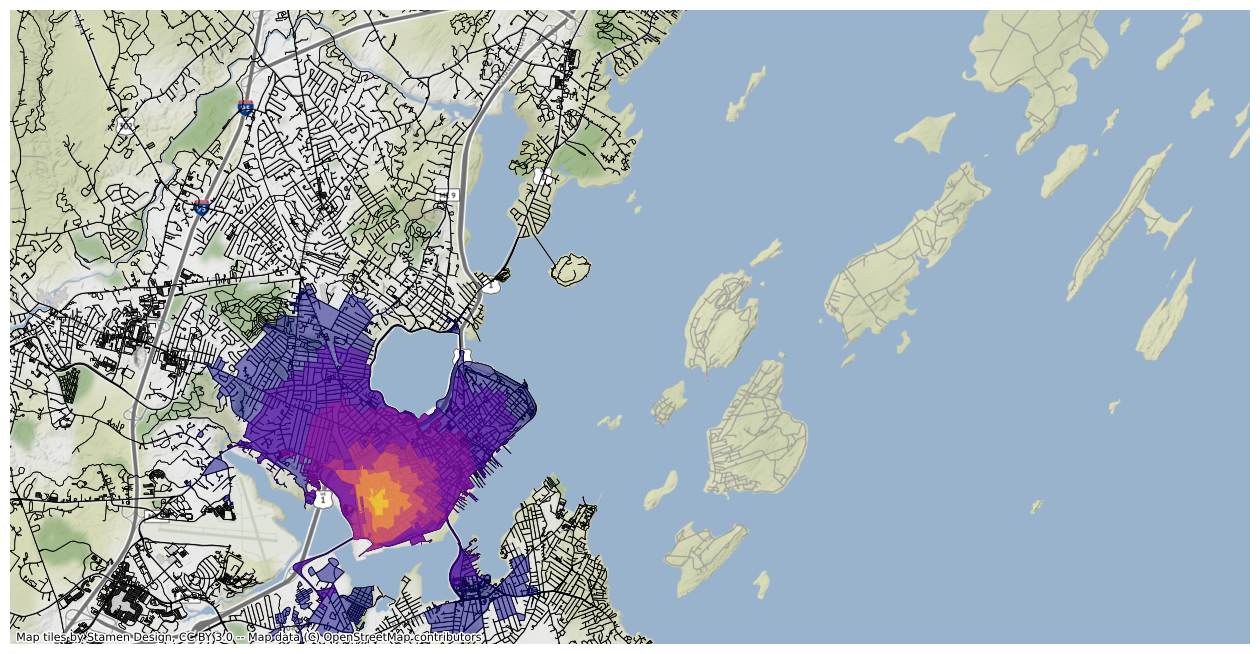

In [67]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G,
    bgcolor=None,
    node_size=0,
    bbox=bbox_nsew,
    edge_color='k',
    edge_linewidth=0.5,
    show=False,
    close=False,
    figsize=(16,9),
    dpi=300
)
iso_poly_gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.5)
cx.add_basemap(ax)

## Load Conserved Lands based on bounding box
The next step is to use the walk time polygons to find conserved lands within each walk time. We start by getting all conserved lands in and near our isochrones.

In [68]:
# make an ESRI geometry JSON object from the bounding box
# https://developers.arcgis.com/rest/services-reference/enterprise/query-map-service-layer-.htm
bbox_json = json.dumps({"points":gdf.geometry.unary_union.envelope.exterior.coords[:]})
bbox_json

'{"points": [[-7828224.792595492, 5407343.851920224], [-7818870.028523669, 5407343.851920224], [-7818870.028523669, 5417095.533335251], [-7828224.792595492, 5417095.533335251], [-7828224.792595492, 5407343.851920224]]}'

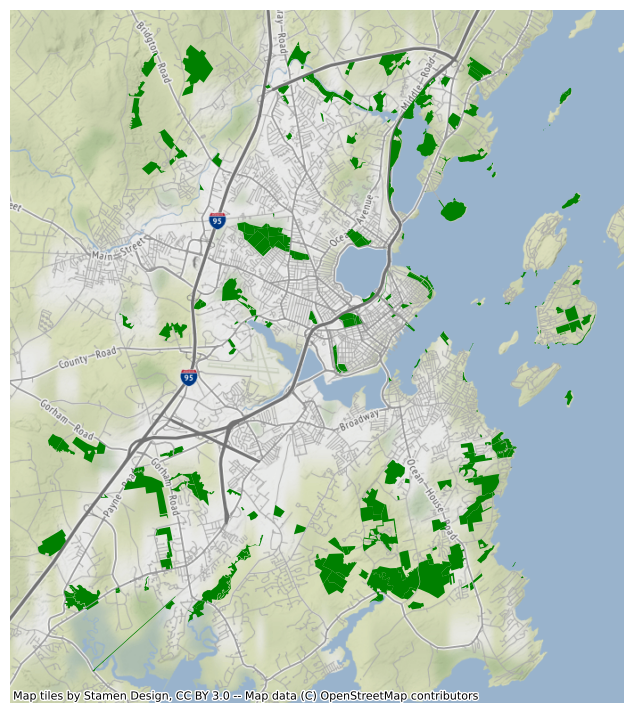

In [120]:
# get all conserved parcels within 3 mile radius of this polygon
lands = gpd.read_file("https://gis.maine.gov/arcgis/rest/services/acf/Conserved_Lands/MapServer/0/query?"+
                      "where=&text=&objectIds=&time=&timeRelation=esriTimeRelationOverlaps&geometry="+
                      urllib.parse.quote(bbox_json)+
                      "&geometryType=esriGeometryMultipoint&inSR=3857&spatialRel=esriSpatialRelEnvelopeIntersects&"+
                      "distance="+str(3)+"&units=esriSRUnit_StatuteMile&outFields=*&returnGeometry=true&returnTrueCurves=false&outSR=3857&returnIdsOnly=false&returnCountOnly=false&returnZ=false&returnM=false&returnDistinctValues=false&returnExtentOnly=false&sqlFormat=none&featureEncoding=esriDefault&f=geojson")
ax = lands.plot(color='g')
ax.axis('off')
cx.add_basemap(ax)

## Identify Conserved Lands within Isochrones
Here again we map each land to its centroid, then each centroid to the nearest graph node.

In [121]:
# use a spatial index to efficiently find nearest nodes
gdf_nodes_cl = ox.graph_to_gdfs(G, edges=False).reset_index()
# find the nearest node and retrieve a list of osmids
lands['osmid'] = gdf_nodes_cl.loc[gdf_nodes_cl.sindex.nearest(lands.centroid)[1]]["osmid"].values
center_nodes_cl_gdf = ox.graph_to_gdfs(G, edges=False).loc[lands['osmid'].tolist()]

Median Distance: 110 m


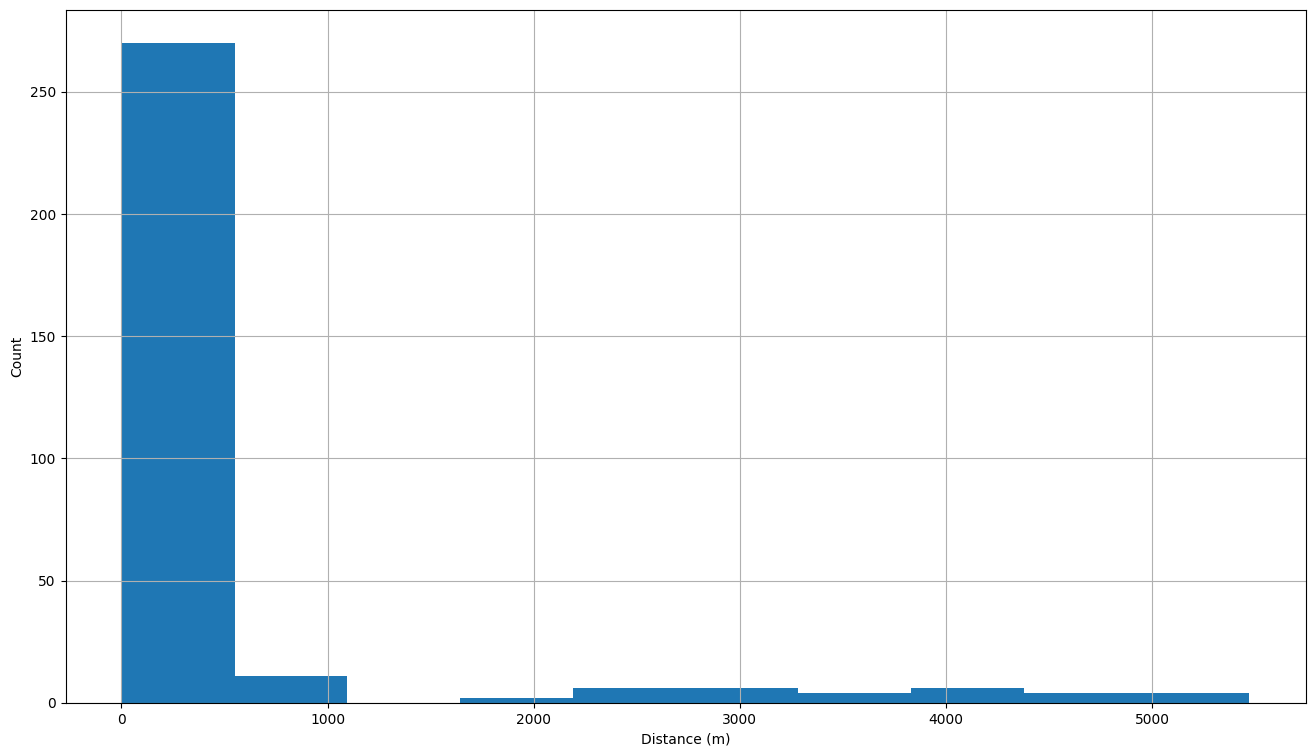

In [122]:
# verify that nodes are reasonably close
center_nodes_cl_gdf['distance'] = center_nodes_cl_gdf.distance(lands.centroid, align=False)
ax = center_nodes_cl_gdf['distance'].hist()
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Count")
print(f"Median Distance: {center_nodes_cl_gdf['distance'].median():3.0f} m")

As with before, we will drop nodes that are too far from the actual centers.

In [123]:
lands = lands[center_nodes_cl_gdf.reset_index()['distance'] < 500]
center_nodes_cl_gdf = center_nodes_cl_gdf[center_nodes_cl_gdf['distance'] < 500]

Median Distance:  93 m


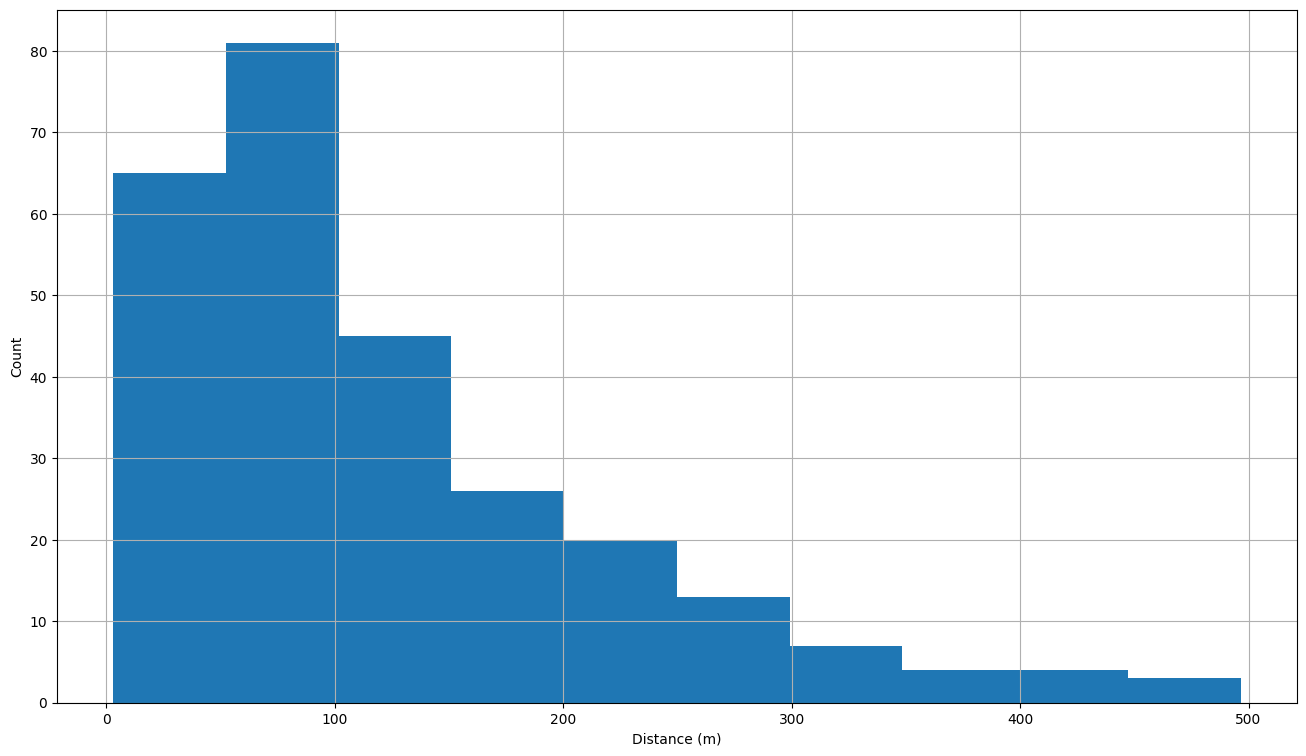

In [124]:
# verify that nodes are reasonably close
ax = center_nodes_cl_gdf['distance'].hist()
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Count")
print(f"Median Distance: {center_nodes_cl_gdf['distance'].median():3.0f} m")

## Calculating Trip Times
As an example, we can take the node we plotted above and look at all the conserved land within different walking distances.

In [137]:
# create a dataframe with the points
lands_points = lands.copy()
lands_points["trip_times"] = [node_times[node] if node in node_times else None for node in lands['osmid'].tolist()]
lands_colors = [node_colors[node] if node in node_colors else "none" for node in lands['osmid'].tolist()]

How many conserved lands are within each trip time?

In [139]:
# calculate the number of lands within each trip time
lands_points.groupby("trip_times")["OBJECTID"].count()

trip_times
5.0      2
10.0     2
15.0     5
20.0     5
30.0     3
45.0    21
60.0    28
Name: OBJECTID, dtype: int64

What area of conserved land is within each trip time?

In [140]:
lands_points.groupby("trip_times")["CALC_AC"].sum()

trip_times
5.0      13.303850
10.0     13.553275
15.0     22.866700
20.0     35.755086
30.0     19.421974
45.0     46.371807
60.0    118.151402
Name: CALC_AC, dtype: float64

Where are these properties on the map?

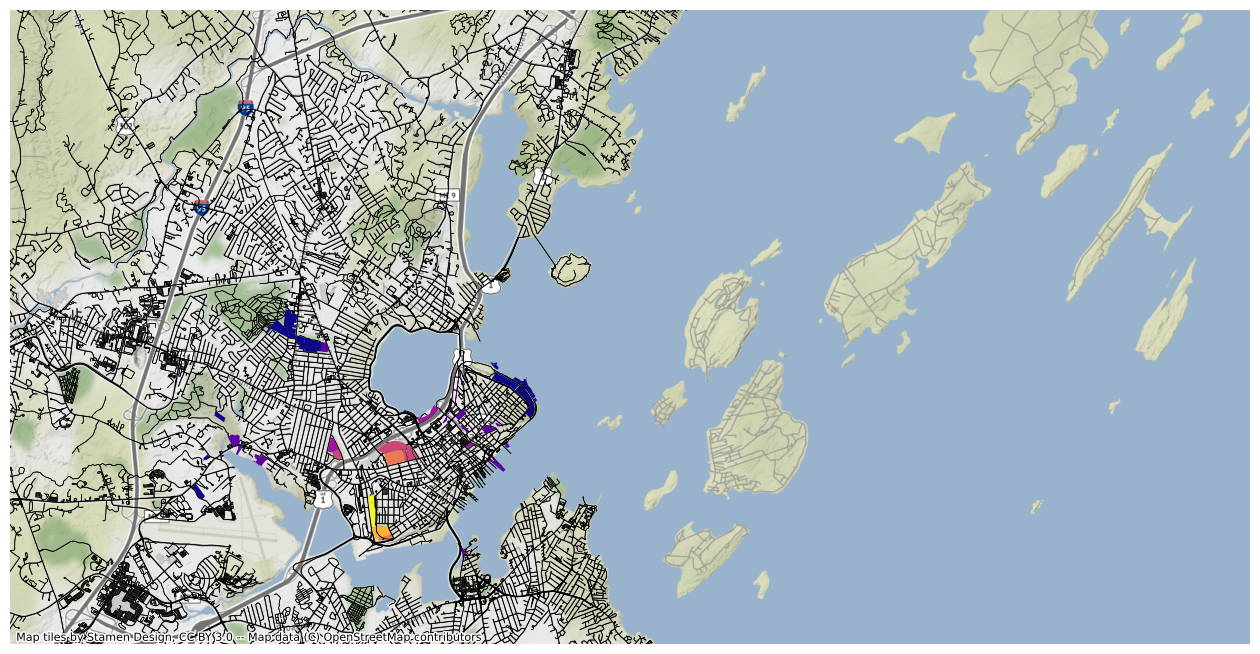

In [142]:
# plot the network then add isochrones as colored polygon patches
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G,
    bgcolor=None,
    node_size=0,
    bbox=bbox_nsew,
    edge_color='k',
    edge_linewidth=0.5,
    show=False,
    close=False,
    figsize=(16,9),
    dpi=300
)
# iso_poly_gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.5)
lands_points.plot(ax=ax, color=lands_colors)
cx.add_basemap(ax)

List the properties by walk time

In [129]:
lands_points.sort_values("trip_times")

created_user   created_date last_edited_user  last_edited_date  \
31   MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
106  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
176  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
29   MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
139  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
..           ...            ...              ...               ...   
306  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
308  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
309  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
310  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
312  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   

           PROJECT   PARCEL_NAME                    DESIGNATION CONS1_TYPE  \
31             NaN     064  E024  Miscellaneous Municipal Lands        Fee   
106            NaN     068  E001  Miscellaneous Municipal Lands        Fee   
176            NaN     070  D010  Miscellaneous Municipal Lands        Fee   
29             NaN     070  C001  Miscellaneous Municipal Lands        Fee   
139            NaN     071  A002  Miscellaneous Municipal Lands        Fee   
..             ...           ...                            ...        ...   
306            NaN     282  A002  Miscellaneous Municipal Lands        Fee   
308  Fort Williams  U48001000000  Miscellaneous Municipal Lands        Fee   
309            NaN     281  A001  Miscellaneous Municipal Lands        Fee   
310            NaN           NaN                            NaN        Fee   
312                      R059025  Miscellaneous Municipal Lands        Fee   

                     HOLD1_NAME HOLD1_TYPE  ... CL_UNIQUEID  \
31   Maine Minor Civil Division  Municipal  ...       10537   
106  Maine Minor Civil Division  Municipal  ...       10617   
176  Maine Minor Civil Division  Municipal  ...       10535   
29   Maine Minor Civil Division  Municipal  ...       10616   
139  Maine Minor Civil Division  Municipal  ...       10542   
..                          ...        ...  ...         ...   
306  Maine Minor Civil Division  Municipal  ...       10609   
308  Maine Minor Civil Division  Municipal  ...        9961   
309  Maine Minor Civil Division  Municipal  ...       10608   
310  Maine Minor Civil Division  Municipal  ...        4218   
312  Maine Minor Civil Division  Municipal  ...       10181   

                                   GlobalID TAX_MAP_TOWN  TAX_MAP_BOOK_LOT  \
31   {06178590-EF56-4DEE-B779-1805D886CD3A}          NaN               NaN   
106  {18AC5462-4365-4F75-B56E-D150C38E2AE6}          NaN               NaN   
176  {96C8D47D-8218-4EDA-A32B-407198841F17}          NaN               NaN   
29   {AFE24ADB-F7BC-486A-9283-C5370E37718A}          NaN               NaN   
139  {2AFEF969-8CBA-4B78-9A44-73B0F4BC824A}          NaN               NaN   
..                                      ...          ...               ...   
306  {E0066CF6-D65C-41D5-88E3-DFBFA5B75423}          NaN               NaN   
308  {01E20C24-6B30-41C6-B58F-7D886A7A9B0E}          NaN               NaN   
309  {7F4FB83F-FAC8-4F68-9525-4DDD359C842A}          NaN               NaN   
310  {527C4C0E-CFB0-4B95-879A-35287178581C}          NaN               NaN   
312  {44CF7C62-0698-4C18-A679-BB1499C0F2D1}          NaN               NaN   

    OBJECTID  Shape.STArea()  Shape.STLength()  \
31     20596    13171.240383        488.163150   
106    19955    40667.529089       1081.365826   
176    21576    39419.661194        770.887861   
29     12040    15428.496386        669.337723   
139    14780     1456.024469        157.306800   
..       ...             ...               ...   
306    17959   145493.773467       1560.240402   
308    17106      464.497216         86.696565   
309    19725    34859.407828       1139.155433   
310    13582    15663.759513    